In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPool2D, Activation, LeakyReLU, Reshape, UpSampling2D, Concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

import kerastuner as kt

import pickle
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print(tf.__version__, tf.test.gpu_device_name())
# tf.config.set_visible_devices([], 'GPU')

2.4.1 /device:GPU:0


In [2]:
DATA_DIRECTORY = 'Z:/fml-final/data/offline_off-policy/'

In [3]:
def state_to_features(game_state: dict) -> np.array:
    X = np.zeros((17, 17, 8), dtype=bool)

    # material
    X[game_state["field"] == -1, 0] = True
    X[game_state["field"] == 0, 1] = True
    X[game_state["field"] == 1, 2] = True

    # explosion
    X[game_state["explosion_map"] > 0, 3] = True
    
    # add bomb countdowns for every field
    for bomb in game_state["bombs"]: X[bomb[0][0], bomb[0][1], 4] = True

    # add coin bool for every field
    for coin in game_state["coins"]: X[coin[0], coin[1], 5] = True

    # add agent info (self) for every field
    X[game_state["self"][3][0], game_state["self"][3][1], 6] = True

    # add agent info (opponent) for every field
    for opponent in game_state["others"]: X[opponent[3][0], opponent[3][1], 7] = True

    return X[1:, 1:, :]

In [4]:
def preprocessed_data_from_file(dir, filename):
    with open(dir + filename, "rb") as file:
        data = pickle.load(file)

    X = []
    y = []

    for transition in data:
        X.append(state_to_features(transition[0]))
        y.append(transition[1])

    return  np.array(X), np.array(y)

In [5]:
def joined_split_data_from_files(directory, filenames, test_size=0.3):
    X_train, X_test, y_train, y_test = list(), list(), list(), list()
    for filename in filenames:
        X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(*preprocessed_data_from_file(directory, filename), test_size=test_size)
        X_train.extend(X_train_new)
        X_test.extend(X_test_new)
        y_train.extend(y_train_new)
        y_test.extend(y_test_new)
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [6]:
def array_splits_of_size(N, array):
    return np.array_split(array, len(array) // N)

In [7]:
encoder_input = Input(shape=(16, 16, 8))
x = Conv2D(512, (3, 3), activation="relu", padding="same")(encoder_input)
x = MaxPool2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)

x = Flatten()(x)

encoder_output = Dense(1024, activation="relu")(x)

action_input = Input(shape=(1,))
action_infused_encoder_output = Concatenate()([encoder_output, action_input])

encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")


decoder_input = Dense(8192, activation="relu")(encoder_output)
x = Reshape((4, 4, 512))(decoder_input)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)

decoder_output = Conv2D(8, (3, 3), activation="relu", padding="same")(x)


autoencoder = tf.keras.Model(inputs=[encoder_input, action_input], outputs=decoder_output, name="autoencoder")
autoencoder.summary()

autoencoder.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=["mse"])

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 8)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 512)  37376       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 512)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 512)    2359808     max_pooling2d[0][0]              
________________________________________________________________________________________

In [8]:
loss_history = []
val_accuracy_history = []

In [10]:
for i in range(2):
    for filenames in tqdm(array_splits_of_size(5, os.listdir(DATA_DIRECTORY))):
        X_train, X_test, y_train, y_test = joined_split_data_from_files(DATA_DIRECTORY, filenames)
        hist = autoencoder.fit(X_train, X_train, epochs=1, batch_size=32, shuffle=True, verbose=True, validation_data=(X_test, X_test)).history
        loss_history.extend(hist["loss"])
        val_accuracy_history.extend(hist["val_accuracy"])

  0%|          | 0/15 [00:42<?, ?it/s]


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node autoencoder/conv2d/Relu (defined at <ipython-input-9-97105f4b0673>:4) ]] [Op:__inference_train_function_1104]

Function call stack:
train_function


In [13]:
best_model.save("conv_net_classifier_best_0")

INFO:tensorflow:Assets written to: conv_net_classifier_0\assets


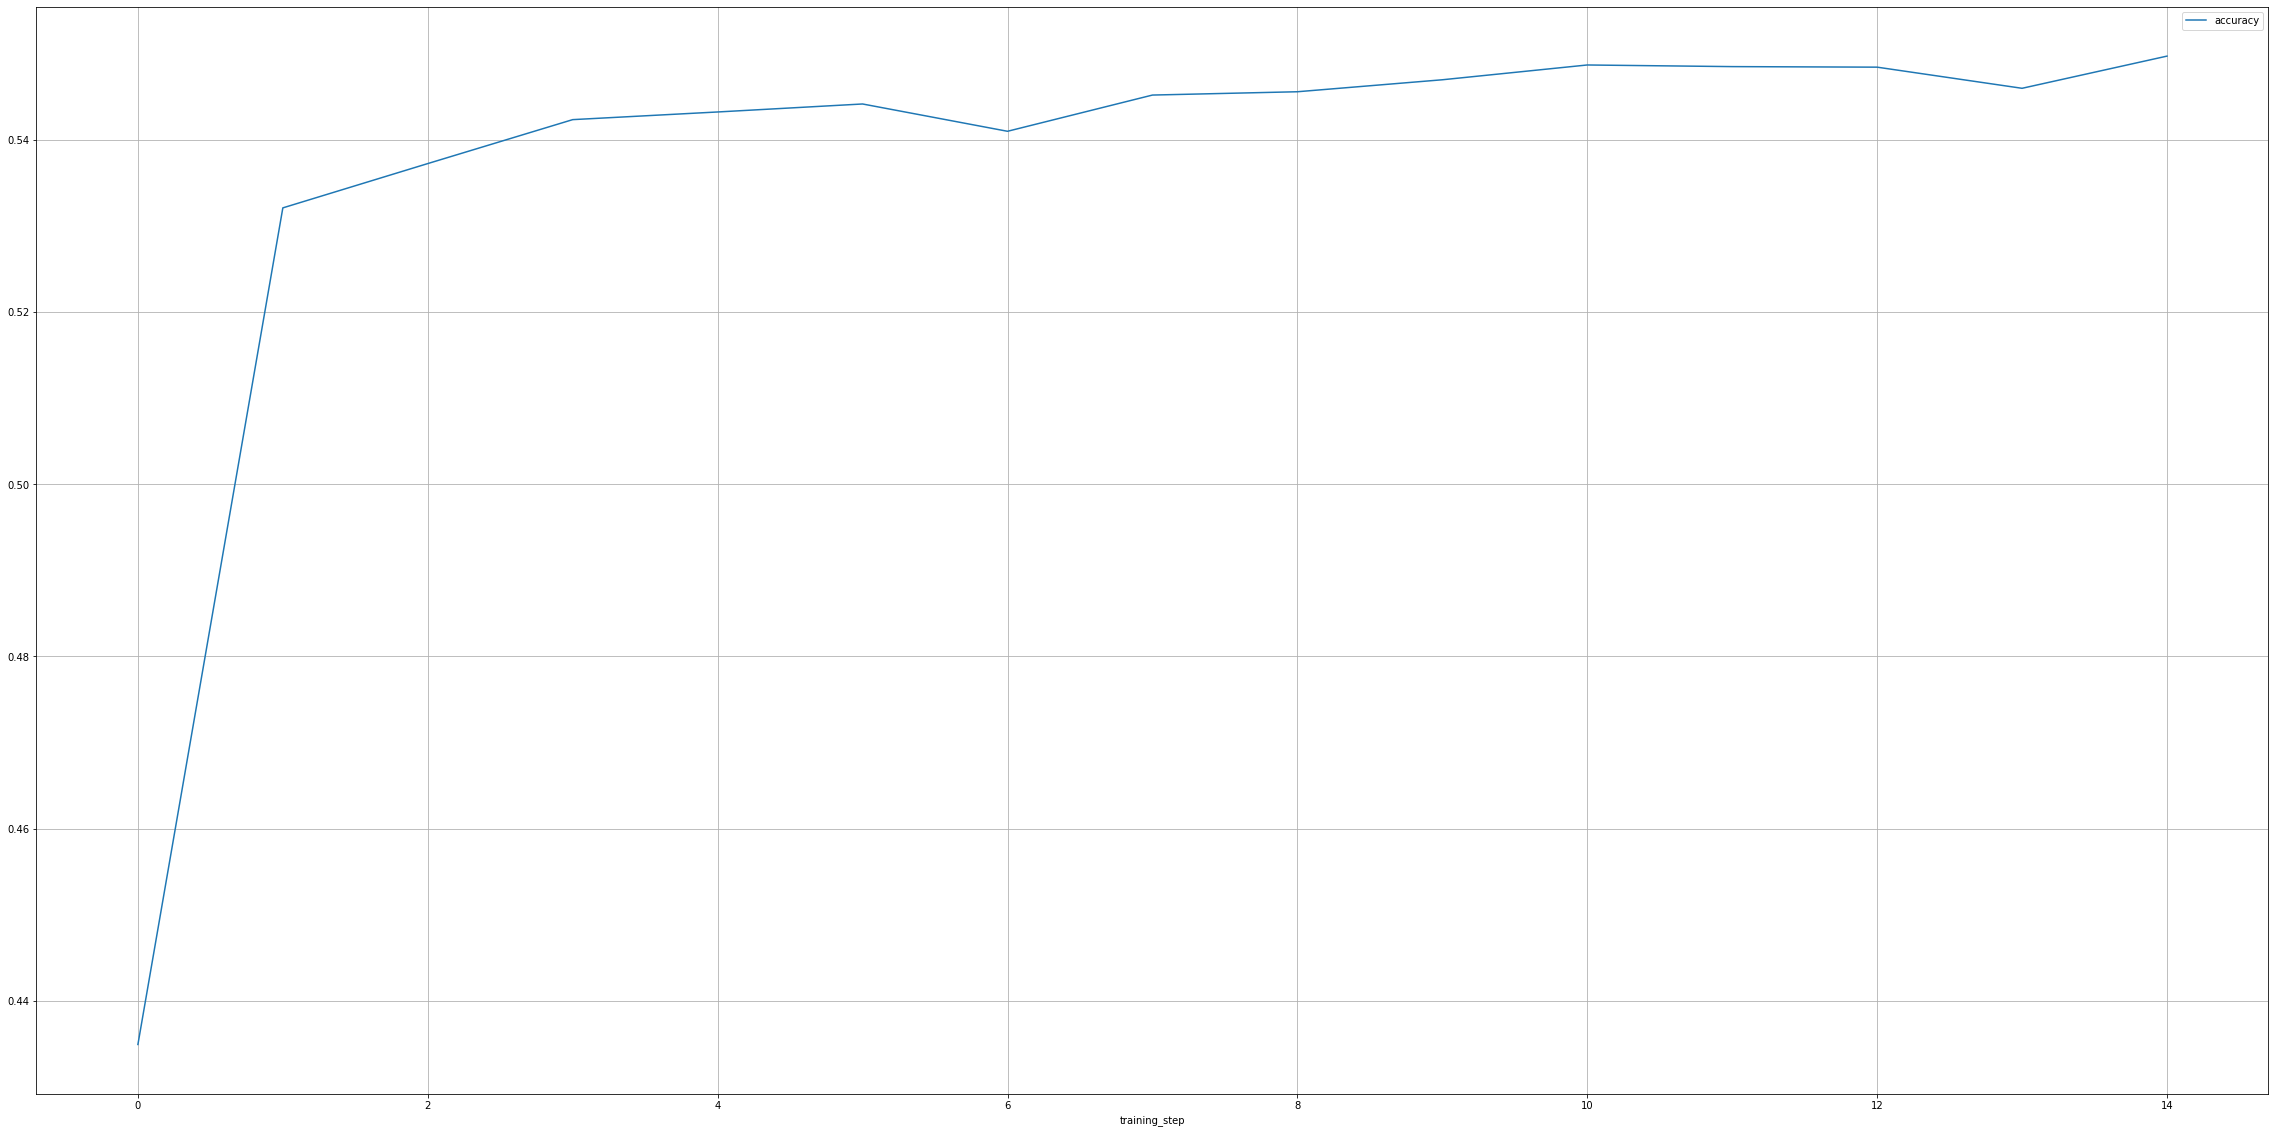

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(40, 20))
# ax.plot(np.arange(len(loss_history)), loss_history, label="loss", alpha=0.5)
ax.plot(np.arange(len(val_accuracy_history)), val_accuracy_history, label="accuracy")
ax.set_xlabel("training_step")
ax.grid("y")
ax.legend();